<a href="https://colab.research.google.com/github/john-vastola/RL-HMS-group/blob/main/basics/RL_group_Basics_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>Reinforcement learning basics | RL discussion group</center>
## <center>A tutorial notebook by John Vastola</center>

<center><img src="https://github.com/john-vastola/RL-HMS-group/blob/main/basics/images/maze_example.png?raw=true" alt="drawing" width="400"/></center>

The goal of this notebook is to present a brief introduction to the basic concepts of reinforcement learning (RL).


The structure of the notebook is as follows:

1.   Mathematical formulation of reinforcement learning problems 
2.   A gridworld environment for studying basic reinforcement learning algorithms
3.   Temporal difference learning as a general model-free prediction algorithm
4.   Q-learning as a general model-free control algorithm
5.    Actor-critic as a general model-free control algorithm 


For more details on everything discussed here, take a look at Sutton and Barto's classic RL textbook. Often considered the 'bible' of RL, it is a must-read if you are serious about learning the subject. 

Read it for free on Sutton's website here: http://incompleteideas.net/book/the-book-2nd.html

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
from IPython.display import HTML, clear_output

%matplotlib inline

---------------------------

## 1. Mathematical formulation of reinforcement learning problems

In this section (which contains no code), we briefly describe the mathematical formulation of reinforcement learning problems. 

### General formulation of reinforcement learning problems

In general, there is an **agent** that exists in an **environment**. At any given time, the environment is in a particular **state**, which determines both (i) what the agent does next, and (ii) how the environment changes next. Depending on what the agent does and the state of the environment, the agent receives a **reward**, and the environment might change.

By 'reward', we include both positive and negative things the agent cares about, so costs are included as negative rewards. The goal of the agent is to maximize total (possibly discounted) reward (or to achieve some morally similar goal, like maximizing reward *rate*). 

More precisely, suppose that the environment is in a state $S_t$ at time $t$. The agent takes an action $A_t$, which yields a reward $R_{t+1}$, and the state of the environment changes to a state $S_{t+1}$. (The agent's action may or may not have contributed to this state change.) This process continues, either until some end condition is met (e.g. a player has won or lost a game), or indefinitely (e.g. a person acting in the world).

The agent acting in the changing environment produces a sequence
\begin{equation}
\cdots \to (S_t, R_t) \to A_t \to (S_{t+1}, R_{t+1}) \to A_{t+1} \to \cdots \ . 
\end{equation}

This process is popularly depicted by a diagram like

<center>
<figure>
<img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/sb_loop.png?raw=true"  width="800"/>
<figcaption>From Sutton and Barto, Ch. 3.</figcaption>
</figure>
</center>


We assume that the agent has a policy $\pi$ that determines which actions it will take. $\pi(A_t | S_t)$ denotes the probability that the agent will take action $A_t$ given that the environment is in a state $S_t$. 

We also assume the environment has some transition function $p(S_{t+1}, R_{t+1} | S_t, A_t)$, which determines the probability that it will transition to a state $S_{t+1}$ and give the agent a reward $R_{t+1}$, given that it was previously in the state $S_t$, and that the agent just took an action $A_t$.

Mathematically, this corresponds to a **Markov decision process**. The key assumption is that both what the agent does (i.e. its policy $\pi$) and how the environment changes (determined by its transition function $p$) only depend on the **most recent state of the environment**, and not on previous ones. 

While this assumption seems pretty strong, it is less problematic than it sounds, since what exactly is considered a 'state' is up to whoever defines the problem. If this formalism (and most of work in RL) is to apply, the notion of 'state' for a given problem should include whatever information is roughly necessary to determine what happens next. While this could include the entire previous history of the environment, in practice the *recent* history of the environment, plus some information related to the internal or latent states of the agent, is sufficient.

### Value functions for assessing the 'goodness' of a policy

In RL, agent performance is tied to reward: more is better. Define the **return** $G_t$ as the discounted future reward
\begin{equation}
G_t := R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots = \sum_{k = t + 1}^T \gamma^{k - t - 1} R_{k} \ .
\end{equation}
The discounting factor $\gamma \in [0, 1]$ determines how much the agent cares about getting rewarded now versus getting rewarded later. It is introduced for two reasons: (i) for RL problems that continue indefinitely, it guarantees that $G_t$ is finite; and (ii) it incentivizes the agent to achieve its goals faster. The value of $\gamma$ is usually chosen to be close to $1$.

In general, the environment may behave somewhat randomly, so maximizing $G_t$ is not always possible, even with 'optimal' behavior. (Even the best poker player can have exceptionally bad luck.) The best an agent can hope for is to behave so that, *on average*, the return $G_t$ is maximized. 

To this end, we define the **value function** (or **state-value function**)
\begin{equation}
v_{\pi}(s) := \mathbb{E}_{\pi}\left[ G_t | S_t = s  \right]
\end{equation}
which quantifies the 'goodness' of being in a state $s$, given that the agent follows a policy $\pi$. We can similarly define the **Q-value function** (or **action-value function**)
\begin{equation}
q_{\pi}(s, a) := \mathbb{E}_{\pi}\left[ G_t | S_t = s, A_t = a  \right]
\end{equation}
which quantifies the 'goodness' of being in a state $s$ and taking an action $a$, given that the agent follows a policy $\pi$. 

It is useful to restate the goal of the agent (maximizing expected return) in terms of these functions. The goal is to find a policy $\pi_*$ which is *optimal*, in the sense that
\begin{equation}
v_{\pi_*}(s) \geq v_{\pi}(s) \ \text{ for all states } s \ ,
\end{equation}
where $\pi$ is any other policy. In words: no matter what state the agent begins in, following $\pi_*$ will yield a greater (or at least as great) expected return than following any other policy. Such a policy always exists for Markov decision processes, although it is generally not unique.

### The prediction and control problems

In general, there are two things we do not know: (i) the expected return of our current policy, and (ii) what the best policy is. 

Determining the expected return of our current policy $\pi$, i.e. evaluating $v_{\pi}(s)$ for all states $s$, is known as the **prediction problem**.

Determining the optimal policy $\pi_*$ is known as the **control problem**.

Solving the prediction problem by itself is clearly not enough to determine good policies. But since evaluating policies helps provide a better idea of how to improve them, it is usually a key component of any good reinforcement learning method for solving the control problem.

In particular, many RL approaches follow the spirit of **generalized policy iteration**: improve the evaluation of your current policy a little, then improve the policy a little, then improve the evaluation of the new policy a little, then improve the policy a little more, and so on.

In what follows, we will cover one possible solution to the prediction problem (temporal difference learning), and two possible solutions to the control problem (Q-learning and actor-critic).

-------------------

## 2. A gridworld environment for studying basic reinforcement learning algorithms

**Gridworld problems**—where an agent moving around on a grid has to navigate to a goal as efficiently as possible—are a classic test case for reinforcement learning algorithms. Because it is easy to get intuition for how an agent *should* behave, it is clear whether policies are being evaluated properly, and whether an agent's current policy is good or bad.

In [ ]:
# @title Gridworld environment codebase

# Check that a proposed board is self-consistent.
# (Should be rectangular; should contain at least one open space; should contain at least one goal.)
def check_consistency(board):
    num_rows, num_cols = len(board), len(board[0])
  
    for i in range(num_rows):   # Check that all rows have same length
        if len(board[i]) != num_cols: return False

    o_count, g_count = 0, 0     # Check for open spaces and goals
    for i in range(num_rows):
        for j in range(num_cols):
            if board[i][j] == 'o': o_count += 1
            if board[i][j] == 'G': g_count += 1
    if o_count == 0: return False
    if g_count == 0: return False
    return True


# Force a proposed board to be self-consistent.
# (Should be rectangular; should contain at least one open space; should contain at least one goal.)
def enforce_consistency(board):
    num_rows = len(board)
    num_cols_all = np.array([len(board[i]) for i in range(num_rows)]) 
    num_cols = np.max(num_cols_all)

    # Make sure board is at least 2 x 2
    if num_rows <= 1: 
        num_rows = 2; board = [ board[0], 'o'*len(board[0]) ]
    if num_cols <= 1: 
        num_cols = 2; 
        for i in range(num_rows): board[i] += 'o'

    num_cols_all = np.array([len(board[i]) for i in range(num_rows)]) 
    num_cols = np.max(num_cols_all)

    if np.sum(np.abs(num_cols_all - num_cols)) != 0:   # Make sure all rows have same length
        for i in range(num_rows): board[i] += (num_cols - num_cols_all[i])*'o'

    
    o_count, g_count = 0, 0    # Make sure there is at least one open space and goal
    for i in range(num_rows):
        for j in range(num_cols):
            if board[i][j] == 'o': o_count += 1
            if board[i][j] == 'G': g_count += 1
    if o_count == 0: board[0] = 'o' + board[0][1:]
    if g_count == 0: board[0] = board[0][0] + 'G' + board[0][2:]
    return board


# Turn a proposed board into a gridworld environment.
def setup_gridworld(board, step_limit=100, goal_reward=10, move_cost=-1):
    board = enforce_consistency(board)
    num_rows, num_cols = len(board), len(board[0])
    
    # Set up state space
    x, y = np.arange(num_cols), np.arange(num_rows)
    state_space = np.array([ (x_, y_) for x_ in x for y_ in y])
    state_space = np.reshape(state_space, (num_cols, num_rows, 2))
    print("State space shape: ", state_space.shape)
    
    # Locate free squares
    free = []
    for i in range(num_rows):
        for j in range(num_cols):
            if board[i][j] == 'o': free.append((j,i))

    # Set up action space
    action_space = ['up', 'down', 'right', 'left']
    action_number = {"up":0, "down":1, "right":2, "left":3}
    num_actions = len(action_space)
    print("Action space: ", action_space)

    # Define dictionary of useful environment-related parameters
    env_params = {"num_rows":num_rows, "num_cols":num_cols, "state_space":state_space, "action_space":action_space, "step_limit":step_limit,
                  "free":free, "num_actions":num_actions, "action_number":action_number, 
                  "goal_reward":goal_reward, "move_cost":move_cost,
                  "board":board}
    return board, env_params


# @title Defining the gridworld environment
def grid_step(state, action, num_steps, env_params):
    board, num_rows, num_cols = env_params['board'], env_params['num_rows'], env_params['num_cols'] 
    goal_reward, move_cost = env_params['goal_reward'], env_params['move_cost']
    step_limit = env_params["step_limit"]
    
    x, y = state
    x_, y_ = x, y

    if action == "up": y_ = (y - 1)*(y > 0)
    elif action == "down": y_ = (y + 1)*(y < (num_rows - 1)) + y*(y == num_rows - 1)
    elif action == "right": x_ = (x + 1)*(x < (num_cols - 1)) + x*(x == num_cols - 1)
    elif action == "left": x_ = (x - 1)*(x > 0)

    if board[y_][x_]!='x': x, y = x_, y_  # Make sure target state is reachable
    state = (x, y)
    
    if board[y][x]=='G':    # Check for reaching goal state
        done = True
        reward = goal_reward + move_cost
    else:
        reward = move_cost
        if num_steps >= step_limit: done = True
        else: done = False

    return state, reward, done


# Randomly initialize gridworld: put agent in a random open (non-goal) space.
def randomly_initialize_gridworld(env_params):
    free = env_params['free']
    state = free[np.random.choice(len(free))]
    return state

In [ ]:
# @title Plotting and visualization code

# This function draws a checkerboard (but does not plot it).
# The generated image shows the configuration of the board, including the
# goal location, the location of obstacles, etc.
def get_checkerboard(ax, board):
    num_rows, num_cols = len(board), len(board[0])

    # Create checkerboard
    checkerboard = np.zeros((num_rows, num_cols))
    for i in range(num_rows): checkerboard[i][i%2::2] = 1
    cmap = LinearSegmentedColormap.from_list("checkerboard", colors=["antiquewhite", "seashell"], N=2)
    ax.imshow(checkerboard, interpolation='nearest', cmap=cmap)

    # Add border
    rect_border = plt.Rectangle((-0.5,-0.5), num_cols, num_rows, fc=None, ec="brown", fill=False)
    ax.add_patch(rect_border)

    # Add obstacles/goals
    for i in range(num_rows):
        for j in range(num_cols):
            square, x, y = board[i][j], j - 0.5, i - 0.5

            if square != 'o':
                if square == 'x': square_color='black'
                if square == 'G': square_color='palegreen'
                
                rect_goal = plt.Rectangle((x, y), 1, 1, fc=square_color, ec=None, fill=True)
                ax.add_patch(rect_goal)

    # Set bounds and remove axes
    ax.set_xlim(-1, num_cols); ax.set_ylim(-1, num_rows); 
    ax.invert_yaxis(); ax.axis('off')
    return ax


# This function plots the board.
def visualize_board(board):
    board = enforce_consistency(board)
    fig, ax = plt.subplots(figsize=(8,6))
    get_checkerboard(ax, board)
    plt.show()
    return


# Visualize the value function.
def visualize_value_function(ax, V, env_params):
    board = env_params['board']
    num_rows, num_cols = len(board), len(board[0])

    get_checkerboard(ax, board)

    # Add in value function annotations
    for i in range(num_rows):
        for j in range(num_cols):
            if board[i][j] == 'o':
                ax.text(j, i, str(round(V[j,i],2)), horizontalalignment='center', verticalalignment='center', fontsize=15)

    ax.set_title("Value function", fontsize=20)
    return


# Generate a set of arrows that represent a policy.
def get_policy_arrows(policy, env_params, policy_params=None):
    state_space = env_params["state_space"]
    board = env_params['board']
    num_rows, num_cols = len(board), len(board[0])

    num_tries = 16    # hyperparameter representing how many action selections we're averaging over

    policy_x, policy_y = np.zeros((num_rows, num_cols)), np.zeros((num_rows, num_cols))
    for x in range(num_cols):
        for y in range(num_rows):
            state = (x, y)
            if board[y][x]=='o':
                px_list, py_list = np.zeros(num_tries), np.zeros(num_tries)
                for i in range(num_tries):
                    action = policy(state, env_params, policy_params)
            
                    if action == "up": px_list[i] = 0; py_list[i] = 1
                    elif action == "down": px_list[i] = 0; py_list[i] = -1
                    elif action == "left": px_list[i] = -1; py_list[i] = 0
                    elif action == "right": px_list[i] = 1; py_list[i] = 0

                policy_x[y, x] = np.mean(px_list)
                policy_y[y, x] = np.mean(py_list)

    return policy_x, policy_y


# Visualize a policy using arrows.
def visualize_policy(ax, policy, env_params, policy_params = None):
    board = env_params['board']
    num_rows, num_cols = len(board), len(board[0])

    policy_x, policy_y = get_policy_arrows(policy, env_params, policy_params)

    get_checkerboard(ax, board)

    # Add in policy arrows
    X_grid, Y_grid = np.meshgrid(np.arange(num_cols), np.arange(num_rows))
    ax.quiver(X_grid, Y_grid, policy_x, policy_y, scale=10,zorder=2)
    ax.set_title("Policy", fontsize=20)
    return


# Visualize policy, value, and prediction error over time in a multi-panel plot.
def visualize_policy_and_value(policy, value, delta, env_params, policy_params = None, name='grid_pv'):
    fig, ax = plt.subplots(1,3, figsize=((24,6)), gridspec_kw={'width_ratios':[1, 1, 2]})   # 12, 6

    visualize_policy(ax[0], policy, env_params, policy_params)
    visualize_value_function(ax[1], V, env_params)

    ax[2].plot(delta, color='red')
    ax[2].set_title("Prediction error", fontsize=20)
    ax[2].set_xlabel("Time step", fontsize=20)
    ax[2].set_ylabel("Prediction error", fontsize=20)
    ax[2].set_title("Prediction error over time", fontsize=20)
    plt.show()
    return


# This function visualizes the current simulation state.
def visualize_simulation_state(state, env_params):
    board = env_params['board']
    x, y = state
    fig, ax = plt.subplots(figsize=(8,6))
    ax = get_checkerboard(ax, board)
    rect_agent = plt.Rectangle((-0.5 +x,-0.5 + y), 1, 1, fc="yellow", ec=None, fill=True)
    ax.add_patch(rect_agent)
    plt.show()
    return


# This function visualizes the current simulation frame (similar to above, but used for video).
def visualize_simulation_frame(ax, state, env_params):
    board = env_params['board']
    x, y = state
    ax = get_checkerboard(ax, board)
    rect_agent = plt.Rectangle((-0.5 +x,-0.5 + y), 1, 1, fc="yellow", ec=None, fill=True)
    ax.add_patch(rect_agent)
    return


# Makes an HTML video of an episode.
def visualize_simulation(state_list, episode_id, env_params):
  fig, ax = plt.subplots(figsize=(8,6))

  def frame(w):
      ax.clear()
      visualize_simulation_frame(ax, state_list[w], env_params)
      ax.set_title("Episode "+str(episode_id[w]), fontsize=20)
      return ax

  anim = animation.FuncAnimation(fig, frame, frames=len(state_list), blit=False, repeat=True)

  html = HTML(anim.to_html5_video())
  plt.close()
  display(html)
  return

In [ ]:
# @title Code for reading in human input

# Read in human action from typed text.
# Can use shortcuts from up/down/left/right.
# If user types in nonsense, chooses action to be 'up'.
def get_human_action():
    action_space = ['up', 'down', 'right', 'left']
    action = input().lower()
    
    if action!='':
        if action[0]=='u': action = 'up'
        if action[0]=='d': action = 'down'
        if action[0] == 'r': action = 'right'
        if action[0] == 'l': action = 'left'
        if action not in action_space: action = 'up'
    return action

State space shape:  (5, 4, 2)
Action space:  ['up', 'down', 'right', 'left']


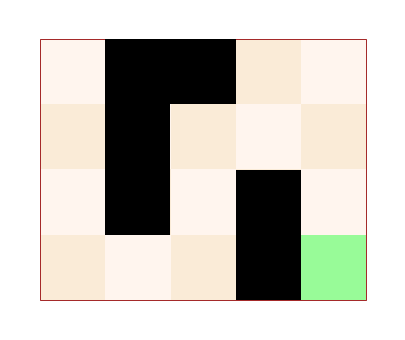

In [ ]:
# Make your own board here. Need at least one open space ('o') and goal space ('G').
# o : open space 
# x : wall (can't go onto or through this square)
# G : goal (positive reward, episode ends when reach this)
board = [ 'oxxoo',
          'oxooo',
          'oxoxo',
          'oooxG' ]

board, env_params = setup_gridworld(board, step_limit=100, goal_reward=10, move_cost=-1)   # Create gridworld environment from board
visualize_board(board)                                                                     # Visualize it 

Try playing it yourself by running the following code!

Also, pay attention to the structure of the loop below. For studying RL, you will often have to implement something like this (perform action, determine consequences, perform action, determine consequences...).

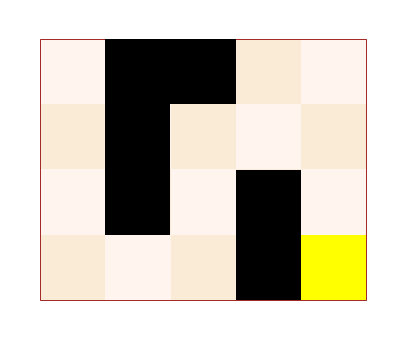

Final score:  5


In [ ]:
state = randomly_initialize_gridworld(env_params)     # Randomly initialize state
num_steps, done, total_reward = 0, False, 0           # Initialize episode progress counters

while True:    # Loop until you reach goal or hit max number of steps.
    visualize_simulation_state(state, env_params)
    print("Total reward: ", total_reward); print('What will you do? (type up/down/left/right, or just press enter to quit)')

    action = get_human_action()
    if action=='': break
    else: 
        state, reward, done = grid_step(state, action, num_steps, env_params)       # Perform the action and see what happens
        num_steps += 1; total_reward += reward
        if done: break

    clear_output(wait=True)
    
clear_output(wait=True)
visualize_simulation_state(state, env_params)
print("Final score: ", total_reward)

Try printing out various things to figure out what states/actions/etc look like. For example:

In [ ]:
state = randomly_initialize_gridworld(env_params)
state = (1,3)
num_steps = 0
print("Starting state: ", state)

action = 'up'
print("Trying action:", action)

state_next, reward, done = grid_step(state, action, num_steps, env_params)
print("State after trying that action: ", state_next)
print("Reward after trying that action: ", reward)
print("Reached goal or hit step count: ", done)

Starting state:  (1, 3)
Trying action: up
State after trying that action:  (1, 3)
Reward after trying that action:  -1
Reached goal or hit step count:  False


Here, states are pairs of numbers $(x, y)$. For a 10x10 grid, $(0,0)$ refers to the square in the top left corner, $(9,0)$ refers to the square in the top right corner, and $(9,9)$ refers to the square in the bottom right corner.

Actions are one of the following: `['up', 'down', 'right', 'left']`.

Rewards are just numbers. The default settings have $-1$ as the reward associated with moving, and $+10$ as the reward associated with reaching a goal square. You can change this by passing in different parameters to the `setup_gridworld` function.

A variety of useful information is contained in the dictionary `env_params`, including the list of strings that represents the board configuration (i.e. where the goal is and where the obstacles are). This is what gets passed to various functions.

In [ ]:
env_params

{'num_rows': 4, 'num_cols': 5, 'state_space': array([[[0, 0],
         [0, 1],
         [0, 2],
         [0, 3]],
 
        [[1, 0],
         [1, 1],
         [1, 2],
         [1, 3]],
 
        [[2, 0],
         [2, 1],
         [2, 2],
         [2, 3]],
 
        [[3, 0],
         [3, 1],
         [3, 2],
         [3, 3]],
 
        [[4, 0],
         [4, 1],
         [4, 2],
         [4, 3]]]), 'action_space': ['up',
  'down',
  'right',
  'left'], 'step_limit': 100, 'free': [(0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (0, 2),
  (1, 2),
  (2, 2),
  (3, 2),
  (4, 2),
  (0, 3),
  (1, 3),
  (2, 3),
  (3, 3)], 'num_actions': 4, 'action_number': {'up': 0,
  'down': 1,
  'right': 2,
  'left': 3}, 'goal_reward': 10, 'move_cost': -1, 'board': ['ooooo',
  'ooooo',
  'ooooo',
  'ooooG']}

Retrieving the following information may be needed for your Q-learning/actor-critic implementations (or at least, it was for mine):

In [ ]:
action_space = env_params["action_space"]
action_number = env_params["action_number"]
num_actions = env_params["num_actions"]

print("Action space: ", action_space)
print("Action number: ", action_number)
print("num_actions: ", num_actions)

Action space:  ['up', 'down', 'right', 'left']
Action number:  {'up': 0, 'down': 1, 'right': 2, 'left': 3}
num_actions:  4


This is because, if you want to choose a random action, one way to do it is to choose a random number between 0 and `num_actions`-1. The `action_number` dictionary is a convenience tool that helps you turn actions like `'up'` into numbers.

### Simulating interactions between the environment and artificial agents

To simulate interactions between artificial agents and the environment, we need two things: (i) something that specifies how the artificial agents act, and (ii) a state-action-reward loop similar to the one above.

Policies map states $[x, y]$ to actions (here: up, down, right, left). Here are some (not particularly effective) example policies:

In [ ]:
# Chooses a random direction to move every time.
def policy_random(state, env_params, policy_params):
    action_space = env_params["action_space"]
    return np.random.choice(action_space)

# Always moves down.
def policy_up(state, env_params, policy_params):
    return "up"

# Always moves right.
def policy_right(state, env_params, policy_params):
    return "right"

# Moves down until it reaches the bottom of the grid, then moves right.
def policy_downright(state, env_params, policy_params):
    num_rows, num_cols = env_params['num_rows'], env_params['num_cols']
    x, y = state

    if y != (num_rows - 1): action = 'down'
    else: action = 'right'
    return action

# Bottom row: move right.
# If on leftmost or rightmost column, but not bottom row: move down.
# Otherwise, for even rows: move left until hits edge.
# For odd rows: move right until hits edge.
def policy_leftrightdown(state, env_params, policy_params):
    num_rows, num_cols = env_params['num_rows'], env_params['num_cols']
    x, y = state

    if y== (num_rows - 1): action = 'right'
    elif (x==0 or x==(num_cols-1)): action = 'down'
    else:
        if y%2 == 0: action = 'left'
        else: action = 'right'
    return action

We would also like our artificial agents to be able to update their behavior as they learn from trial and error. We will assume they do so through functions of the following form:

In [ ]:
# Just an example to show you the form of 'update' rules. 
# The temporal difference / Q-learning / actor-critic functions should look like this, but with details filled in.
def update_example(move_info, policy, V, policy_params, learning_params):

    # Agent updates its behavior somehow
    # e.g. updates value function estimate or policy parameters

    delta = 0    # reward prediction error; for this trivial example, nothing is ever learned

    return policy_params, V, delta

The below code simulates the state-action-reward loop of an agent interacting with the environment. 

The agent steps through the environment many times, for many episodes. At each time step, it improves its value function and/or policy estimates.

In [ ]:
# Simulate gridworld using an artificial agent that learns from trial and error.
def simulate_gridworld(policy, value, update, env_params, learning_params, policy_params = None, num_episodes = 500):
    state_list, episode_list, delta_list = [], [], []    # Initialize lists of data

    for i in range(num_episodes):      # Simulate for many episodes.

        state = randomly_initialize_gridworld(env_params)     # Randomly initialize state
        state_list.append(state), episode_list.append(i+1)    # Add initial state info to state and episode lists
        num_steps, done = 0, False                            # Initialize episode progress counters

        while True:         # Step forward in time until episode is over.
            action = policy(state, env_params, policy_params)                                       # Choose an action according to the policy
            state_new, reward, done = grid_step(state, action, num_steps, env_params)               # Perform the action and see what happens
            move_info = {"state":state, "state_new":state_new, "reward":reward, "action":action}    # Summary of move info

            policy_params, value, delta = update(move_info, policy, value, policy_params, learning_params)     # Use that info to update

            state_list.append(state_new), episode_list.append(i+1), delta_list.append(delta)   # Record info for plotting      
            num_steps, state = num_steps + 1, state_new                                        # Update state and move on

            if done: break          # If hit max number of steps or reached goal, end this episode

    return policy_params, value, delta_list, state_list, episode_list

Alternatively, if you are only interested in simulating your agent's current behavior, you can use the following slightly simpler code:

In [ ]:
# Simulate gridworld using an artificial agent (no learning).
def simulate_gridworld_trained(policy, env_params, policy_params = None, num_episodes = 500):
    state_list, episode_list = [], []         # Initialize lists of data

    for i in range(num_episodes):      # Simulate for many episodes.

        state = randomly_initialize_gridworld(env_params)     # Randomly initialize state
        state_list.append(state), episode_list.append(i+1)    # Add initial state info to state and episode lists
        num_steps, done = 0, False                            # Initialize episode progress counters

        while True:         # Step forward in time until episode is over.
            action = policy(state, env_params, policy_params)                                       # Choose an action according to the policy
            state_new, reward, done = grid_step(state, action, num_steps, env_params)               # Perform the action and see what happens

            state_list.append(state_new), episode_list.append(i+1)                             # Record info for plotting      
            num_steps, state = num_steps + 1, state_new                                        # Update state and move on

            if done: break          # If hit max number of steps or reached goal, end this episode

    return state_list, episode_list

The below code simulates the agent interacting with the environment, and then visualizes the result as a video.

In [ ]:
# Choose policy for the agent to use
policy = policy_random
V, update = np.zeros_like(env_params['state_space']), update_example

policy_params, V, delta_list, state_list, episode_list = simulate_gridworld(policy, V, update, env_params, learning_params={}, num_episodes = 3)  # Simulate


show_simulation =  True; frame_cap = 200   # Optional (and kind of slow) but informative: show simulation
if show_simulation: visualize_simulation(state_list[:frame_cap], episode_list[:frame_cap], env_params)

------------------

## 3. Temporal difference learning as a general model-free prediction algorithm

The temporal difference (TD) learning algorithm is a general-purpose prediction algorithm, and the backbone of much of modern RL.

### Motivation for the TD algorithm

A useful fact is that the value function satisfies the **Bellman equation**, which reads
\begin{equation}
v_{\pi}(s) = \sum_{s', r, a} p(s', r | s, a) \pi(a | s) \left[ \ r + \gamma v_{\pi}(s') \ \right] \ .
\end{equation}
This equation is the basis for dynamic programming methods for solving reinforcement learning problems; such methods, while extremely interesting, only apply when the agent knows a perfect model of how the environment changes with time.

More usefully for our purposes, this equation is *also* the basis for the **temporal difference learning** algorithm for solving the prediction problem.

Suppose the agent would like to evaluate a policy $\pi$, and only obtains state and reward information from the environment (i.e. the agent has no model, accurate or not, of the environment's dynamics). 

Suppose, moreover, that the agent was recently in a state $s$, took an action $a$, received a reward $r$, and transitioned to a state $s'$. The Bellman equation says that
\begin{equation}
v_{\pi}(s) \approx r + \gamma v_{\pi}(s')
\end{equation}
on average, for the true value function $v_{\pi}(s)$. 

The idea behind the TD learning algorithm is to iteratively update $V_{\pi}(s)$, an estimate of the true value function, by comparing the left- and right-hand sides of that approximate equality. The difference between the two is extremely special, and is called the **prediction error**:
\begin{equation}
\delta := r + \gamma V_{\pi}(s') - V_{\pi}(s) \ .
\end{equation}
The name comes from the fact that $r + \gamma V_{\pi}(s')$ is an estimate of $G_t$, the return. Effectively, $\delta$ measures the difference between the apparent value of $G_t$, and the current best estimate ($V_{\pi}(s)$). 


### The TD algorithm

<center>
<figure>
<img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/TDalgo.png?raw=true"  width="800"/>
</figure>
</center>


### TD algorithm implementation

**Implement the TD algorithm.**

In [ ]:
# Implementation of the TD algorithm for solving the prediction problem.
def update_value_TD(move_info, policy, V, policy_params, learning_params):
    alpha, gamma, dt = learning_params["alpha"], learning_params["gamma"], learning_params["dt"]
    state, state_new, reward = move_info["state"], move_info["state_new"], move_info["reward"]

    ###### YOUR CODE HERE

    delta = ...
    #################

    return policy_params, V, delta

### TD policy evaluation

Using the below learning parameters, show that the TD learning rule successfully determines the value function of various policies: e.g. `policy_random` or `policy_downright`.

In [ ]:
# Define learning parameters
alpha, gamma, dt = 0.1, 1, 1
learning_params = {"alpha":alpha, "gamma":gamma, "dt":dt}

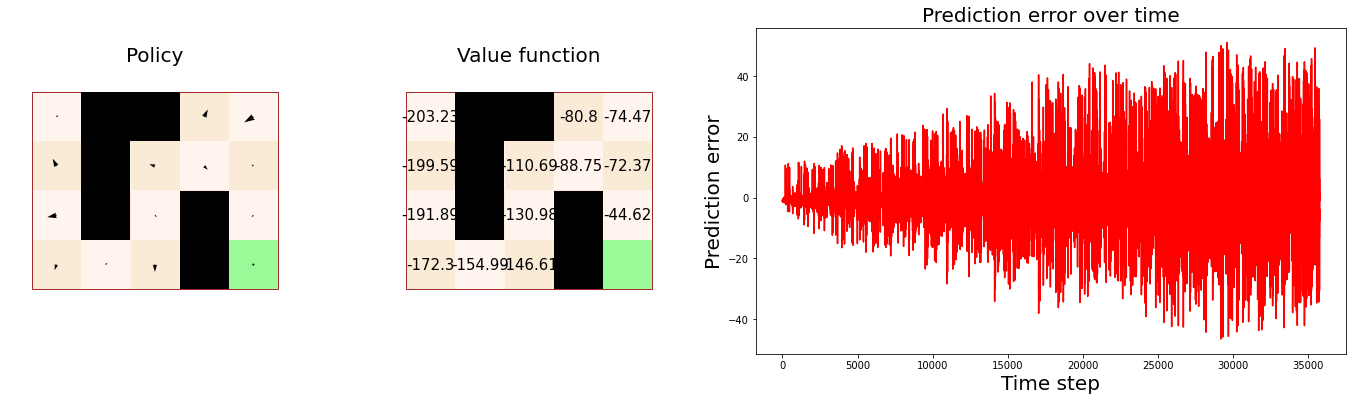

In [ ]:
# Choose policy, then evaluate it
num_cols, num_rows = env_params['num_cols'], env_params['num_rows']
V = np.zeros((num_cols, num_rows))

policy = policy_random
update = ...              # YOUR CODE HERE ####################################

policy_params, V, delta_list, state_list, episode_list = simulate_gridworld(policy, V, update, env_params, learning_params, num_episodes = 500)


visualize_policy_and_value(policy, V, delta_list, env_params, name='grid_random')  # visualize policy, value, prediction error

show_simulation =  True; frame_cap = 200   # Optional (and kind of slow) but informative: show simulation
if show_simulation: visualize_simulation(state_list[:frame_cap], episode_list[:frame_cap], env_params)

-----------------

## 4. Q-learning as a general model-free control algorithm

The TD learning algorithm works fairly well as a general, model-free approach to solving the prediction problem; what about the control problem? Two foundational approaches are **Q-learning** and **actor-critic architectures**. Neither approach requires having a model of the environment, and both work by trial-and-error policy improvement. Both approaches utilize TD learning as a component (i.e. for policy evaluation), but they differ in how they use prediction error information to perform policy improvement.

### Motivation for the Q-learning algorithm

Suppose we had an estimate $Q(s, a)$ of the optimal action-value function $q_*(s, a)$, i.e.
\begin{equation}
Q(s, a) \approx q_*(s, a) = \max_{\pi} \ \mathbb{E}\left[ G_t | S_t = s, A_t = a \right] \ .
\end{equation}
If $Q(s, a)$ were *equal* to $q_*(s, a)$, by definition, the optimal action would be to pick the action $a$ for which $Q(s, a)$ is largest (with ties broken arbitrarily). This suggests that we can convert knowledge about $Q(s, a)$ into a reasonable policy by picking 'greedy' actions.

But $Q(s, a)$ is generally not equal to the true $q_*(s, a)$, and it may not even be very close, so the greedy policy is generally not optimal. 

The idea behind **Q-learning** is to combine this idea with a **method for exploration**. The agent should sometimes take actions it would not normally take (in the sense of not being greedy with respect to $Q$); if it receives the expected amount of reward, great! If not, update $Q$! 

$Q$ can be updated in response to new information just like $V$ is updated in the TD algorithm (and mathematically, this also ultimately comes from the Bellman equation).

The exploration strategy we consider here is to be **epsilon-greedy**: take a greedy action with respect to the current $Q$ estimate with probability $1 - \epsilon$, and take a random action with probability $\epsilon$. 




### The Q-Learning algorithm

<center>
<figure>
<img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/QLearningalgo.png?raw=true"  width="800"/>
</figure>
</center>

### Q-learning implementation

**Implement the Q-learning algorithm, as well as epsilon-greedy action selection.**

*Hint: For the update function, start with the TD learning code and think about what needs to be added.*

*Also note that `Q[state][action]` accesses the Q-value of being in a state `state` and taking an action `action`.*

In [ ]:
# Given the Q-value function, implements epsilon-greedy action selection.
def policy_e_greedy_Q(state, env_params, policy_params):
    action_space = env_params["action_space"]
    Q, epsilon = policy_params["Q"], policy_params["epsilon"]

    # YOUR CODE HERE ######################




    #############################
    return action


# Implementation of tabular Q-learning.
def update_Q_and_policy_QLearning(move_info, policy, Q, policy_params, learning_params):
    # YOUR CODE HERE ################


    delta = ...
    ################################
    policy_params["Q"] = Q             # Update policy

    return policy_params, Q, delta


# Utility function used to visualize the learned value function; computes V(s) using Q(s, a)
def convert_Q_to_V(Q):
  V = np.amax(Q, axis=2)
  return V

### Q-learning evaluation

Let's test the tabular Q-learning algorithm above on our gridworld environment, and see if our agent can use it to learn good policies.

In [ ]:
# Define learning parameters
alpha, gamma, dt = 0.1, 1, 1
learning_params = {"alpha":alpha, "gamma":gamma, "dt":dt}

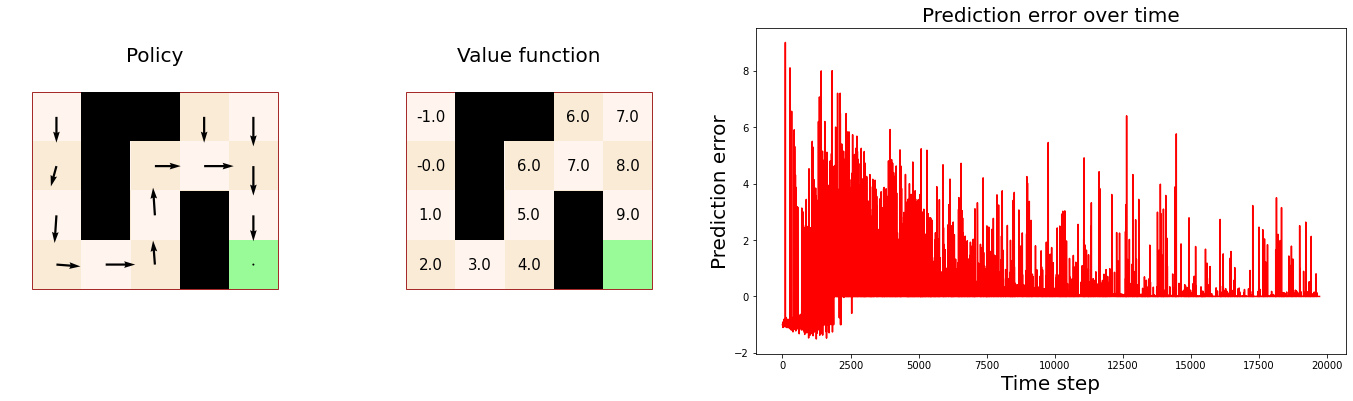

In [ ]:
# Choose policy, then evaluate it
num_cols, num_rows, num_actions = env_params['num_cols'], env_params['num_rows'], env_params['num_actions']
Q, epsilon = np.zeros((num_cols, num_rows, num_actions)), 0.1
policy_params = {"Q":Q, "epsilon":epsilon}
policy = ...         #### YOUR CODE HERE
update = ...         #### 

policy_params, Q, delta_list, state_list, episode_list = simulate_gridworld(policy, Q, update, env_params, learning_params, policy_params, num_episodes = 3000)


V = convert_Q_to_V(Q)
visualize_policy_and_value(policy, V, delta_list, env_params, policy_params, name='Q')  # visualize policy, value, prediction error

show_simulation =  False; frame_cap = 500    # Optional (and kind of slow) but informative: show simulation
if show_simulation: visualize_simulation(state_list[:frame_cap], episode_list[:frame_cap], env_params)

Visualize trained behavior:

In [ ]:
state_list, episode_list = simulate_gridworld_trained(policy, env_params, policy_params, num_episodes = 500)

frame_cap = 100; visualize_simulation(state_list[:frame_cap], episode_list[:frame_cap], env_params)

------------

## 5. Actor-critic as a general model-free control algorithm

### Motivation for the actor-critic algorithm

While Q-learning is certainly useful and important, it is not without problems. One problem is that the Q-value function is closely linked with the agent's policy, creating a conflict between exploration and exploitation: it is optimal to be greedy when $Q$ is accurate, but better to explore different possible actions while learning.

One possibility is to accept that, given a Q-learning strategy with a fixed amount of exploration (e.g. epsilon-greedy with a fixed $\epsilon$), the agent will randomly take bad actions even after learning; alternatively, one must come up with a schedule for reducing exploration with time. This can be done, but it is hard, and often very problem-specific.

**Actor-critic architectures** represent yet another alternative. The basic idea is to represent the policy in a way that is independent of the value function. For example, one can use **action preferences** $h(s, a)$, so that the agent's policy $\pi(a | s)$ can be written as a softmax expression
\begin{equation}
\pi(a | s) = \frac{e^{h(s, a)}}{\sum_b e^{h(s, b)}} \ .
\end{equation}

The action preferences need to be iteratively updated, for example by gradient descent (the value function itself serves as a suitable objective function here). For more information on the technical details, look up the **policy gradient theorem**.

The 'actor-critic' designation comes from the structure of the algorithm. The actor corresponds to the policy $\pi$, which is parameterized by action preferences. The critic corresponds to the value function $V$. One can imagine that the critic computes a prediction error, and then feeds this information to the actor ("Do that more!" or "Do that less!"). The actor then adjusts their performance, the critic offers more feedback, the actor adjusts again, and so on.

### The actor-critic algorithm

<center>
<figure>
<img src="https://github.com/john-vastola/RL-at-Harvard-tutorial-2022/blob/main/images/ACalgo.png?raw=true"  width="800"/>
</figure>
</center>

### Actor-critic implementation

**Implement an actor-critic architecture.**

**You need to implement both softmax action preferences, and the function that updates values / action preferences.**

*Hint: Note that `h[state][action]` accesses the agent's preference for action `action` when in state `state`.*

In [ ]:
# Given action preferences h, selects action via a softmax.
def policy_pref_tabular_actorcritic(state, env_params, policy_params):
    action_space = env_params["action_space"]
    h = policy_params["h"][state]

    ###### YOUR CODE HERE

    ####################
    return action


# Implementation of actor-critic.
def update_V_and_policy_tabular_actorcritic(move_info, policy, V, policy_params, learning_params):
    alpha, gamma, dt = learning_params["alpha"], learning_params["gamma"], learning_params["dt"]
    state, state_new, reward = move_info["state"], move_info["state_new"], move_info["reward"]
    action, action_number, num_actions = move_info["action"], env_params["action_number"], env_params["num_actions"]
    action_ = action_number[action]

    h = policy_params["h"]

    ########### YOUR CODE HERE
    
    delta = ...      
    ######################

    pi = np.exp(h)/np.sum(np.exp(h))

    for a in range(num_actions):
        if a == action_: grad_pi_over_pi = 1 - pi
        else: grad_pi_over_pi = - pi
        policy_params["h"][state][a] += ...  # Policy gradient update   YOUR CODE HERE
    return policy_params, V, delta

### Actor-critic evaluation

Let's test the tabular actor-critic algorithm above on our gridworld environment, and see if our agent can use it to learn good policies.

In [ ]:
# Define learning parameters
alpha, gamma, dt = 0.1, 1, 1
learning_params = {"alpha":alpha, "gamma":gamma, "dt":dt}

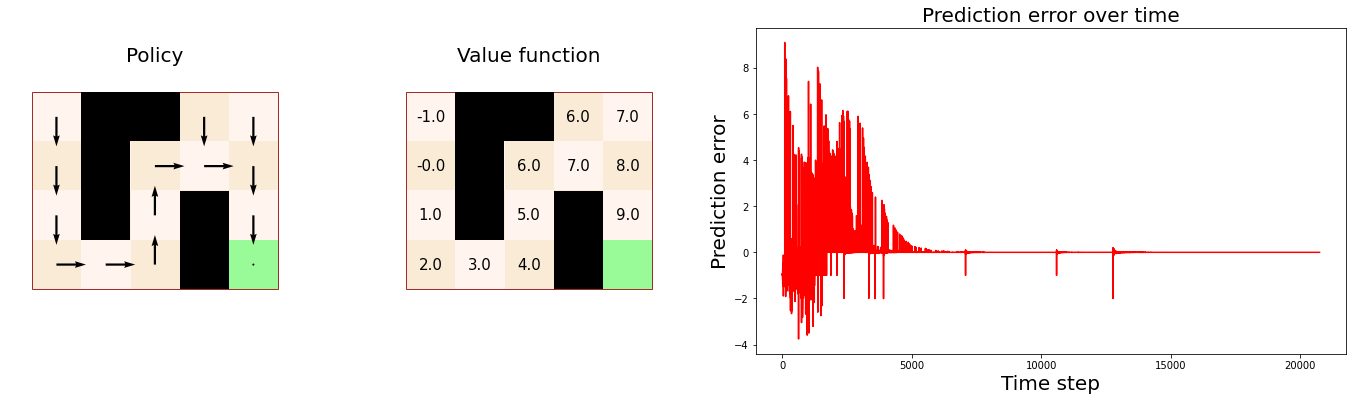

In [ ]:
# Choose policy, then evaluate it
num_cols, num_rows, num_actions = env_params['num_cols'], env_params['num_rows'], env_params['num_actions']
V = np.zeros((num_cols, num_rows))
h = np.zeros((num_cols, num_rows, num_actions))
policy_params = {"h":h}
policy = ...               ###### YOUR CODE HERE
update = ...               ########### 

policy_params, V, delta_list, state_list, episode_list = simulate_gridworld(policy, V, update, env_params, learning_params, policy_params, num_episodes = 3500)


visualize_policy_and_value(policy, V, delta_list, env_params, policy_params, name='actor_critic') # visualize policy, value, prediction error

show_simulation =  False; frame_cap = 1000   # Optional (and kind of slow) but informative: show simulation
if show_simulation: visualize_simulation(state_list[:frame_cap], episode_list[:frame_cap], env_params)

Visualize trained behavior:

In [ ]:
state_list, episode_list = simulate_gridworld_trained(policy, env_params, policy_params, num_episodes = 500)

frame_cap = 100; visualize_simulation(state_list[:frame_cap], episode_list[:frame_cap], env_params)

-------------------